In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from os import getcwd
TRAIN = os.path.join(getcwd(), 'MinHash/data/articles_1000.train')
TRUTH = os.path.join(getcwd(), 'MinHash/data/articles_1000.truth')

In [3]:
# mapping
# cache the index of every docid for O(1) query later
def docid_map(docids):
    docid_col_map = dict()
    for i in range(0, len(docids)):
        docid_col_map[docids[i]] = i
    return docid_col_map    

In [4]:
def parse_data(filename):
    if not filename:
        raise ValueError("filename is empty.")
    
    import string
    
    with open(filename) as f:
        content = f.readlines()  # read lines from filename
        content = [x.strip() for x in content]
        exclude = set(string.punctuation)
        tuples = list()
        
    for line in content:
        id, article = line.split(" ", 1)
        article = ''.join(ch for ch in article if ch not in exclude).replace(' ', '').lower()
        tuples.append((id, article))  # construct tuple of id and text
    return tuples 

In [5]:
def shingle_document(string, k):
    if not string:
        raise ValueError("String is empty.")
    if not k:
        raise ValueError("k is empty.")
    
    import binascii
    
    unique_hash = set() # initialize set data structure
    for i in range(0, len(string) - k + 1):
        unique_hash.add(binascii.crc32(string[i:i+k].encode("utf-8"))) # has substring into 32-bit integer
        
    return unique_hash

In [6]:
########################
# test parse_data()
dd = parse_data(TRAIN)

In [7]:
def shingled_list(document):
    shingled_list = list()
    for d in document:
        shingled_list.append((d[0], shingle_document(d[1], 10))) # shingle_document()
    return shingled_list

In [8]:
########################
# test shingled_list()
shingled_dd = shingled_list(dd)

In [9]:
def jaccard(a, b):
    if not a:
        raise ValueError("a is empty.")
    if not b:
        raise ValueError("b is empty.")
        
    a = set(a)
    b = set(b)

    return len(a.intersection(b))/len(a.union(b)) # return raio of union and intersection

In [10]:
def similarity(filename, k):
    if not filename:
        raise ValueError("filename is empty.")
    if not k:
        raise ValueError("k is empty.")
        
    tuples = parse_data(filename)  # parse a file with data
    tuples_js = list()

    n = len(tuples)

    for i in range(0, n - 1):
        id_i, article_i = tuples[i]
        if k > len(article_i):
            raise ValueError("k is out of bound.")

        for j in range(i + 1, n):
            id_j, article_j = tuples[j]
            if k > len(article_j):
                raise ValueError("k is out of bound.")

            s = jaccard(shingle_document(article_i, k), shingle_document(article_j, k)) # shingle_document()
            tuples_js.append((id_i, id_j, s))
    
    return tuples_js # return a list of tuples, each tuple contains: (id1, id2, s)

In [11]:
########################
# test similarity()
# similarity(TRAIN, 10)

In [12]:
# inversion
def _invert_shingles(shingled_documents): # input a list of tuples of form (id, [items])
    if not shingled_documents:
        raise ValueError("filename is empty")
        
    tuples = list() # initialize list for tuples

    for row in shingled_documents:
        for item in row[1]:
            tuples.append((item, row[0]))
    return tuples

In [13]:
 def getKey(item):
        return item[0]

In [14]:
# sorting
def invert_shingles(shingled_documents):
    if not shingled_documents:
        raise ValueError("filename is empty")
    tuples = list()
    ids = list() # initialize list for document ids
    
    for row in shingled_documents:
        ids.append(row[0])
        
    tuples = sorted(_invert_shingles(shingled_documents), key = getKey) # invert_shingles_(), getKey()

    return tuples, ids

In [15]:
############################
# test invert_shingles()
inverted = invert_shingles(shingled_dd)

In [16]:
# generate hash functions
import random        

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

def make_hashes(num_hash):
    hash_fns = list() # initialize list for hash functions
    
    for i in range(0, num_hash):
        hash_fns.append(make_random_hash_fn()) # make_random_hash_fn()
        
    return hash_fns

In [17]:
def make_minhash_signature(shingled_data, num_hashes):
    inv_index, docids = invert_shingles(shingled_data) # invert_shingles()
    num_docs = len(docids)

    # print(inv_index)
    # print(type(inv_index))
    # print(len(inv_index))
    # print(len(inv_index[0]))
    
    docid_col_map = docid_map(docids) # docid_map
    # print(docid_col_map)
    
    unique_items = {item[0] for item in inv_index}
    sorted_unique_items = sorted(unique_items)
  
    # initialize the signature matrix with infinity in every entry
    sigmatrix = np.full([num_hashes, num_docs], np.inf)
    
    # generate hash functions
    hash_funcs = make_hashes(num_hashes) # make_hashes()
    
    # iterate over each non-zero entry of the characteristic matrix
    # docid locates in both characteristics matrix and signature matrix
    # row retains the row index value
    # use the same hash functions calculate through rows with the same docid and put the minimum value into sigmatrix

    for row, docid in inv_index:
        # i = row_map[row] # index of rows
        j = docid_col_map[docid] # index of columes
        for n in range(0, num_hashes):
            sigmatrix[n][j]= min(hash_funcs[n](row), sigmatrix[n][j]) # why don't we add % len(sorted_unique_items)?
    
    return sigmatrix

In [18]:
########################
# test make_minhash_signature()
minhash_sigmat = make_minhash_signature(shingled_dd, 2)

In [19]:
def minhash_similarity(id1, id2, minhash_sigmat):

    similarity = 0
    
    for i in range(0, len(minhash_sigmat)):
        if  minhash_sigmat[i][id1] == minhash_sigmat[i][id2]:
            similarity = similarity + 1
    
    return similarity/len(minhash_sigmat)

In [20]:
########################
# test minhash_similarity()
# minhash_similarity(0, 0, minhash_sigmat)

In [21]:
def minhash_similarity_all(shingled_doc, num_hashes):
    inv_index, docids = invert_shingles(shingled_doc) # invert_shingles()
    
    MinHash_Matrix = np.zeros((len(docids), len(docids)))
    tuples = list()
    
    minhash_sigmat = make_minhash_signature(shingled_dd, num_hashes) # make_minhash_signature()
    
    docid_col_map = docid_map(docids) # docid_map()
    # print(docid_col_map)
    
    for d1 in docids:
        i = docid_col_map[d1]
        for d2 in docids:
            j = docid_col_map[d2]
            if i < j:
                MinHash_Matrix[i][j] = minhash_similarity(i, j, minhash_sigmat) # minhash_similarity()
                tuples.append((d1, d2, MinHash_Matrix[i][j]))
            
    return MinHash_Matrix, tuples

In [22]:
########################
# test minhash_similarity_all()
# minhash_similarity_all = minhash_similarity_all(shingled_dd, 50)

In [23]:
# minhash_similarity_matrix = minhash_similarity_all[0] 
# minhash_similarity_tuples = minhash_similarity_all[1]

In [24]:
########################
# check for consistency
# print(minhash_similarity_matrix)
# print(minhash_similarity_tuples)

In [25]:
jaccard_similarity_tuples = similarity(TRAIN, 10)
js = pd.DataFrame(jaccard_similarity_tuples)

In [26]:
js.columns = ["id1", "id2", "js"]

In [27]:
num_hashes = 100

dt = list()
    
for k in range(1, num_hashes + 1):
    
    # compare jaccard_similarity_tuples and minhash_similarity_tuples    
    minhash_similarity_tuples = minhash_similarity_all(shingled_dd, k)[1]
    mh = pd.DataFrame(minhash_similarity_tuples)
    mh.columns = ["id1", "id2", "mh"]
    
    # all_tuples = jaccard_similarity_tuples + minhash_similarity_tuples 
    # data[k-1] = (len(all_tuples) - len(set(all_tuples)))/len(jaccard_similarity_tuples)
       
    # use min squared error
    df = pd.merge(js, mh, on = ["id1", "id2"])
    df["diff"] = (df.js - df.mh) ** 2
    mse = df["diff"].sum()
    rmse = math.sqrt(mse/len(df))
    fraction = np.mean(js.js == mh.mh)
    num = k
    dt.append((num, rmse, fraction))

dt = pd.DataFrame(dt, columns = ["num", "rmse", "fraction"])

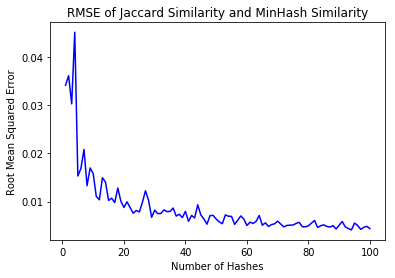

In [30]:
plt.plot(dt.num, dt.rmse, color = "blue")
plt.title("RMSE of Jaccard Similarity and MinHash Similarity")
plt.xlabel("Number of Hash Functions")
plt.ylabel("Root Mean Squared Error")
plt.show()

#### What is the effect of the number of hash functions used to compute the Minhash signature on the accuracy of the Minhash estimate of Jaccard similarity. 

### My thoughts:
#### 1. It is known to all that the probability of two min-hash values equalling is the Jaccard similarity for that two documents. However, the realization of the probability could be very different. Therefore, we are estimating Jaccard similarity instead of calculating it. Given the law of large numbers, we expect that with more experiements, which are hash functions in our case, we will have a better estimation which is closer to the expected value, namely a better accuracy of the Minhash estimate of Jaccard similarity.

#### 2. After calculating the Root Mean Squared Error (RMSE) of Jaccard Similarity and MinHash Similarity, it is obvious that as the number of hash functions increases, the accurary of Minhash estimate of Jaccard similarity increases. We can see that the most dramatic decrease of RMSE happens around number of hash functions equaling to 5, and after the number of hash functions hits 60, RMSE levels out.